In [1]:
import numpy as np
import astropy as ast
import matplotlib.pyplot as plt

from astropy import units as u

In [2]:
# Fixed constants

dir = '/data/vxtest/519'
adjust = 80

In [3]:
# Modifiable constants

cluster = 228

tenMy_start = 1010
tenMy_end = 1390 # max due to halofile skipping after that
snap_interval = 1

tout_ref = 930 + 80
max_t_since_out = 0.4

halo_mass_threshold = 1e7
distance_threshold_for_plot = 15

In [4]:
def get_phi(vector: np.ndarray) -> float:
    """Return the azimuthal angle of vector (in conventional spherical coordinates).
    """
    
    if vector[0] > 0:
        return np.arctan(vector[1] / vector[0])
    elif vector[0] < 0 :
        return np.arctan(vector[1] / vector[0]) + np.pi
    else:
        if vector[1] > 0:
            return np.pi / 2
        elif vector[1] < 0:
            return -np.pi / 2
        else:
            return 0

In [5]:
def get_theta(vector: np.ndarray) -> float:
    """Return the polar angle of vector (in conventional spherical coordinates).
    """
    
    rho = np.sqrt(np.sum(vector ** 2))
    
    if rho != 0:
        return np.arccos(vector[2] / rho)
    else:
        return np.pi / 2

In [6]:
def build_triple_rotation_matrix(ref_r: np.ndarray, ref_L: np.ndarray) -> np.ndarray:
    """Return a matrix object to transform vectors to from an original coordinate system
    to a coordinate system where (x = ref_r, y = 0, z = 0) and z points along ref_L.
    """
    
    # get the angles of spherical coordinates of ref_r
    phi = get_phi(ref_r)
    theta = get_theta(ref_r)
    
    # rotation 1 rotates around z-axis 
    rotation_1 = np.zeros([3, 3])
    
    rotation_1[0][0] = np.cos(phi)
    rotation_1[0][1] = np.sin(phi)
    rotation_1[1][0] = -np.sin(phi)
    rotation_1[1][1] = np.cos(phi)
    rotation_1[2][2] = 1
    
    # rotation 2 rotates around new y-axis
    rotation_2 = np.zeros([3, 3])
    
    rotation_2[0][0] = np.sin(theta)
    rotation_2[0][2] = np.cos(theta)
    rotation_2[2][0] = -np.cos(theta)
    rotation_2[2][2] = np.sin(theta)
    rotation_2[1][1] = 1
    
    double_rotation = rotation_2 @ rotation_1
    
    # rotate ref_L by rotation_1 then rotation_2
    interm_L = double_rotation @ ref_L
    
    # rearrange components of interm_L to get azimuthal angle w.r.t. x instead of z
    pseudo_L = np.array([
        interm_L[1],
        interm_L[2],
        interm_L[0]
    ])
    
    pseudo_phi = get_phi(pseudo_L)
    
    # rotation_3 rotates around new x-axis
    rotation_3 = np.zeros([3, 3])
    
    rotation_3[0][0] = 1
    rotation_3[1][1] = np.sin(pseudo_phi)
    rotation_3[1][2] = -np.cos(pseudo_phi)
    rotation_3[2][1] = np.cos(pseudo_phi)
    rotation_3[2][2] = np.sin(pseudo_phi)
    
    return rotation_3 @ double_rotation

In [7]:
def n_sigma_clipping(max_longitude_rad: float, longitudes_rad: np.ndarray, values: np.ndarray,
                     w: float, max_value: float, min_value: float, n: float) -> tuple:
    """Return the list of longitudes (in degrees) between -max_longitude_rad and max_longitude_rad where 
    there are stars within +/- w degrees and their angular moment is between min_value and max_value and the 
    list of average angular momentum in each of those ranges and the list of standard deviations in angular 
    momentum in each of those ranges, given a star cluster's longitudes_rad and values, both recalculated after 
    excluding values greater than n original standard deviations.
    """

    degs = []
    avg_delta_Lz = []
    std_delta_Lz = []

    for deg in np.arange(-max_longitude_rad * u.rad.to(u.deg), max_longitude_rad * u.rad.to(u.deg) + 1):

        delta_Lz_list = []

        for star in range(len(longitudes_rad)):

            if deg - w <= longitudes_rad[star] * u.rad.to(u.deg) < deg + w\
            and min_value <= values[star] <= max_value:
                delta_Lz_list.append(values[star])

        if delta_Lz_list != []:

            mean = np.mean(delta_Lz_list)
            sigma = np.std(delta_Lz_list)
            
            new_delta_Lz_list = []
            
            for v in delta_Lz_list:
                if abs(v - mean) <= n * sigma:
                    new_delta_Lz_list.append(v)
                    
            if new_delta_Lz_list != []:
                degs.append(deg)
                avg_delta_Lz.append(np.mean(new_delta_Lz_list))
                std_delta_Lz.append(np.std(new_delta_Lz_list))
            
    return(np.array(degs), avg_delta_Lz, std_delta_Lz)

In [8]:
def make_sci_notation_str(num: float, precision=2) -> str:
    """Return a LaTeX-formated string for the sceintific notation of num with decimal places 
    determined by precision.
    """
    
    sci = str(np.format_float_scientific(m, precision))
    
    first = ''
    
    i = 0
    while sci[i] != 'e':
        first += sci[i]
        i += 1
    
    second = sci[-2:]
    
    if second[0] == '0':
        second = second[-1]
        
    return first + r' $\times$ 10$^{' + second + r'}$ M$_\odot$'

In [9]:
def get_radial_velocity(r_vector: np.ndarray, v_vector: np.ndarray) -> np.ndarray:
    """Return the radial velocity vector with respect to the origin given position r_vector and 
    total velocity v_vector.
    """
    
    numer = r_vector @ v_vector
    denom = r_vector @ r_vector
    
    return (numer / denom) * r_vector

In [10]:
# Prepare dictionary d containing dictionaries d[snap]

snap_start = tenMy_start - adjust
snap_end = tenMy_end - adjust

snaps = np.arange(snap_start, snap_end + 1, snap_interval)

d = {}
cluster_d = {}

# for t in snaps:
#     d[str(t)] = {}

In [11]:
toutfile = dir + '/TOUT' + str(tout_ref - adjust).zfill(4)

# thead = np.fromfile(toutfile, dtype='double', count=1)
# Tend = thead[0] # = 10.1
# Toffset = 14.1 - Tend # = 4

nnn = np.fromfile(toutfile, dtype='int32', count=3, offset=8)
ntc = nnn[1]

# nstart = nnn[0]
# nts = nnn[2]

noff = 8 + (3 * 4)

outid = []
t_since_out = []

for c in range(ntc):
    
    readout_c = np.fromfile(toutfile, dtype='int32', count=1, offset=noff)
    newcount = readout_c[0]
    noff += 4
    
    readout_n = np.fromfile(toutfile, dtype='int32', count=newcount, offset=noff)
    outid.append(readout_n)
    noff += 4 * newcount
    
    readout_t = np.fromfile(toutfile, dtype='double', count=newcount, offset=noff)
    t_since_out.append(readout_t)
    noff += 8 * newcount

recently_out = t_since_out[cluster] < max_t_since_out

In [12]:
####

In [13]:
# Cell below must change for new cluster choice depending on other results

In [14]:
encounter_time = 11.77
encounter_snap = round(100 * encounter_time - adjust)
interval = 20

t1 = str((encounter_snap) - interval)
t2 = str((encounter_snap) + interval)

snap_before_and_after = (t1, t2)

encounter_range = np.arange(int(t1), int(t2) + 1)

In [15]:
####

In [16]:
avg_Lz = []
std_Lz = []
len_Lz = []

encounter_time_axis = []

distances_sorted_by_t = []
times_sorted_by_t = []
masses_sorted_by_t = []

In [17]:
# Not-actually-fill all dictionaries d

for snap in snaps:
    
    snap = str(snap)

    mainfile = dir + '/snapshot_' + snap.zfill(4)
    halofile = dir + '/halos/h' + snap + '.z0.000.AHF_halos'

    hd = np.fromfile(mainfile,dtype='int32',count=7)
    d['nd'] = hd[2]
    d['ns'] = hd[5]
    d['nc'] = hd[3]
    d['nb'] = hd[4]
    
    head = np.fromfile(mainfile,dtype='double',count=7,offset=4+6*4)
    d['time'] = head[6]
    
    start_d = 0
    start_c = d['nd']
    start_b = d['nd'] + d['nc']
    start_s = d['nd'] + d['nc'] + d['nb']
    block = d['nd'] + d['nc'] + d['ns'] + d['nb']

    if d['nb'] > 0:
        skipx = 256 + 3*4 + start_b*3*8
        skipv = 256 + 5*4 + (block*3 + start_b*3)*8
        d['rc'] = np.fromfile(mainfile,dtype='double',count=3,offset=skipx)
        d['vc'] = np.fromfile(mainfile,dtype='double',count=3,offset=skipv)
        d['xh'] = d['rc'][0]
        d['yh'] = d['rc'][1]
        d['zh'] = d['rc'][2]
        d['vxh'] = d['vc'][0]
        d['vyh'] = d['vc'][1]
        d['vzh'] = d['vc'][2]
    
    skipx = 256 + 3*4 + start_c*3*8
    skipv = 256 + 5*4 + (block*3 + start_c*3)*8
    skipi = 256 + 7*4 + block*3*2*8 + start_c*4
    d['rc'] = np.fromfile(mainfile, dtype='double', count=3*d['nc'], offset=skipx)
    d['vc'] = np.fromfile(mainfile, dtype='double', count=3*d['nc'], offset=skipv)
    d['idc'] = np.fromfile(mainfile, dtype='uint32', count=d['nc'], offset=skipi)
    d['jxc'] = d['rc'][0::3] - d['xh']
    d['jyc'] = d['rc'][1::3] - d['yh']
    d['jzc'] = d['rc'][2::3] - d['zh']

    d['jvxc'] = d['vc'][0::3] - d['vxh']
    d['jvyc'] = d['vc'][1::3] - d['vyh']
    d['jvzc'] = d['vc'][2::3] - d['vzh']

    d['idc'] -= d['nd']
    ki = np.zeros(d['nc'], dtype='int32')
    for j in range(d['nc']):
        ix = d['idc'][j]
        ki[ix] = j

    d['xc'] = d['jxc'][ki]
    d['yc'] = d['jyc'][ki]
    d['zc'] = d['jzc'][ki]

    d['vxc'] = d['jvxc'][ki]
    d['vyc'] = d['jvyc'][ki]
    d['vzc'] = d['jvzc'][ki]

    d['rh3'] = [d['xh'], d['yh'], d['zh']]
    d['vh3'] = [d['vxh'], d['vyh'], d['vzh']]
    
    #centers unsorted
    d['jrc3'] = np.reshape(d['rc'], (d['nc'], 3)) - d['rh3']
    d['jvc3'] = np.reshape(d['vc'],(d['nc'], 3)) - d['vh3']
 
    d['rc3'] = d['jrc3'][ki]
    d['vc3'] = d['jvc3'][ki]
 
    skipx = 256 + 3*4 + start_s*3*8
    skipv = 256 + 5*4 + block*3*8 + start_s*3*8 #skip over r, and dm+c v's
    skipi = 256 + 7*4 + block*3*2*8 + start_s*4 #skip over r and v and dm+c id
    skipc = 256 + 9*4 + block*(2*3*8+4) + start_s*4 #skip over r, v and id and dm+c ic

    d['rs'] = np.fromfile(mainfile, dtype='double', count=3*d['ns'], offset=skipx)
    d['vs'] = np.fromfile(mainfile, dtype='double', count=3*d['ns'], offset=skipv)
    d['ids'] = np.fromfile(mainfile, dtype='uint32', count=d['ns'], offset=skipi)
    d['jics'] = np.fromfile(mainfile,dtype='uint32',count=d['ns'],offset=skipc)

    d['jrs3'] = np.reshape(d['rs'], (d['ns'], 3)) - d['rh3']
    d['jvs3'] = np.reshape(d['vs'], (d['ns'], 3)) - d['vh3']
 
    d['ids'] -= d['nd'] + d['nc'] + d['nb']
    ki = np.zeros(d['ns'], dtype='int32')
    for j in range(d['ns']):
        ix = d['ids'][j]
        ki[ix] = j

    d['rs3'] = d['jrs3'][ki]
    d['vs3'] = d['jvs3'][ki]
    d['ics'] = d['jics'][ki]

    # there is a change in shape vs the previous method;  
    # adapt to select the right array axis instead of skip by 3 along a single 1-d
    
    d['xs'] = d['rs3'][:,0]
    d['ys'] = d['rs3'][:,1]
    d['zs'] = d['rs3'][:,2]
    d['vxs'] = d['vs3'][:,0]
    d['vys'] = d['vs3'][:,1]
    d['vzs'] = d['vs3'][:,2]
    
    # distance from centre of galaxy
    d['ds'] = np.sqrt(d['xs'] ** 2 + d['ys'] ** 2 + d['zs'] ** 2)
    

    dh = np.loadtxt(halofile)
    
    d['halom'] = dh[:,3] #halo mass. The file also has various radii and velocities
    d['halor'] = dh[:,12]
    d['hx'] = dh[:,5]
    d['hy'] = dh[:,6]
    d['hz'] = dh[:,7]
    d['hvx'] = dh[:,8]
    d['hvy'] = dh[:,9]
    d['hvz'] = dh[:,10]

    #need to use the same xh, vxh etc for the center of mass as used for the stars
    d['halox'] = d['hx'] - d['xh']
    d['haloy'] = d['hy'] - d['yh']
    d['haloz'] = d['hz'] - d['zh']
    d['halovx'] = d['hvx'] - d['vxh']
    d['halovy'] = d['hvy'] - d['vyh']
    d['halovz'] = d['hvz'] - d['vzh']
    
    
    # I think this reorders and selects only the cluster
    cluster_d['out_x'] = d['rs3'][outid[cluster], 0]
    cluster_d['out_y'] = d['rs3'][outid[cluster], 1]
    cluster_d['out_z'] = d['rs3'][outid[cluster], 2]
    
    cluster_d['out_vx'] = d['vs3'][outid[cluster], 0]
    cluster_d['out_vy'] = d['vs3'][outid[cluster], 1]
    cluster_d['out_vz'] = d['vs3'][outid[cluster], 2]

    # Median of out_x,y,z only if recently out
    cluster_d['out_x_median'] = np.median(cluster_d['out_x'][recently_out])
    cluster_d['out_y_median'] = np.median(cluster_d['out_y'][recently_out])
    cluster_d['out_z_median'] = np.median(cluster_d['out_z'][recently_out])
    
    cluster_d['out_vx_median'] = np.median(cluster_d['out_vx'][recently_out])
    cluster_d['out_vy_median'] = np.median(cluster_d['out_vy'][recently_out])
    cluster_d['out_vz_median'] = np.median(cluster_d['out_vz'][recently_out])
    
    
    
    ###begin analyze

    select = (d['ics'] == cluster)

    cluster_x = d['xc'][cluster]
    cluster_y = d['yc'][cluster]
    cluster_z = d['zc'][cluster]
    cluster_r = np.array([cluster_x, cluster_y, cluster_z])

    cluster_vx = d['vxc'][cluster]
    cluster_vy = d['vyc'][cluster]
    cluster_vz = d['vzc'][cluster]
    cluster_v = np.array([cluster_vx, cluster_vy, cluster_vz])

    cluster_L = np.cross(cluster_r, cluster_v)

    transform = build_triple_rotation_matrix(ref_r=cluster_r, ref_L=cluster_L)

    new_cluster_r = transform @ cluster_r
    new_cluster_L = transform @ cluster_L

    new_cluster_Lx = new_cluster_L[0]
    new_cluster_Ly = new_cluster_L[1]
    new_cluster_Lz = new_cluster_L[2]

    ####
    stars_d = d['ds'][select]
    ####

    
    # Difference from previous version:
    # The following 6 variables collects only "recently out" positions and velocities
    
    stars_x = cluster_d['out_x'][recently_out]
    stars_y = cluster_d['out_y'][recently_out]
    stars_z = cluster_d['out_z'][recently_out]

    stars_vx = cluster_d['out_vx'][recently_out]
    stars_vy = cluster_d['out_vy'][recently_out]
    stars_vz = cluster_d['out_vz'][recently_out]

    new_stars_Lx = []
    new_stars_Ly = []
    new_stars_Lz = []

    new_stars_x = []
    new_stars_y = []
    new_stars_z = []

    for i in range(len(stars_x)):

        star_x = stars_x[i]
        star_y = stars_y[i]
        star_z = stars_z[i]
        star_r = [star_x, star_y, star_z]

        star_vx = stars_vx[i]
        star_vy = stars_vy[i]
        star_vz = stars_vz[i]
        star_v = [star_vx, star_vy, star_vz]

        star_L = np.cross(star_r, star_v)
        new_star_L = transform @ star_L

        new_stars_Lx.append(new_star_L[0])
        new_stars_Ly.append(new_star_L[1])
        new_stars_Lz.append(new_star_L[2])

        new_star_r = transform @ star_r

        new_stars_x.append(new_star_r[0])
        new_stars_y.append(new_star_r[1])
        new_stars_z.append(new_star_r[2])

    new_stars_Lx = np.array(new_stars_Lx)
    new_stars_Ly = np.array(new_stars_Ly)
    new_stars_Lz = np.array(new_stars_Lz)

    new_stars_x = np.array(new_stars_x)
    new_stars_y = np.array(new_stars_y)
    new_stars_z = np.array(new_stars_z)

    new_stars_delta_Lx = new_stars_Lx - new_cluster_Lx
    new_stars_delta_Ly = new_stars_Ly - new_cluster_Ly
    new_stars_delta_Lz = new_stars_Lz - new_cluster_Lz

    new_stars_L_perp = np.sqrt((new_stars_delta_Lx) ** 2 + (new_stars_delta_Ly) ** 2)

    new_stars_rho = np.sqrt(new_stars_x ** 2 + new_stars_y ** 2 + new_stars_z ** 2)

    # longs and lats formulae taken from previous notebook
    stars_longitudes = np.arctan2(new_stars_y, new_stars_x)
    stars_latitudes = np.arcsin(new_stars_z / new_stars_rho)

    
    avg_Lz.append(np.mean(new_stars_delta_Lz))
    std_Lz.append(np.std(new_stars_delta_Lz))
    len_Lz.append(len(new_stars_delta_Lz))
    
    this_time = d['time']
    encounter_time_axis.append(this_time)
    
    
    distances = []
    times = []
    masses = []

    for i in range(len(d['halom'])):
        
        mass = d['halom'][i]
    
        if mass >= halo_mass_threshold:
            
            delta_x = d['halox'][i] - cluster_d['out_x_median']
            delta_y = d['haloy'][i] - cluster_d['out_y_median']
            delta_z = d['haloz'][i] - cluster_d['out_z_median']
            
            dist = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
            
            distances.append(dist)
            times.append(d['time'])
            masses.append(mass)           
        
    distances_sorted_by_t.append(distances)
    times_sorted_by_t.append(times)
    masses_sorted_by_t.append(masses)

In [18]:
plus_err = []
minus_err = []

for i in range(len(len_Lz)):
    
    err = std_Lz[i] / np.sqrt(len_Lz[i])
    plus_err.append(avg_Lz[i] + err)
    minus_err.append(avg_Lz[i] - err)

In [19]:
# plt.figure(figsize=(150, 5))
# plt.rc('font', size=14)

# # plt.axvline(x=encounter_time_1, ls='--', color='royalblue', lw=2.5, label='Close encounter\nwith DM subhalo')
# # plt.axvline(x=encounter_time_2, ls='--', color='royalblue', lw=2.5)
# # plt.axvline(x=encounter_time_3, ls='--', color='royalblue', lw=2.5)
# # plt.axvline(x=encounter_time_4, ls='--', color='royalblue', lw=2.5)
# # plt.axvline(x=encounter_time_5, ls='--', color='royalblue', lw=2.5)
# # plt.axvline(x=encounter_time_6, ls='--', color='royalblue', lw=2.5)
# # plt.axvline(x=encounter_time_7, ls='--', color='royalblue', lw=2.5)

# for i in range(len(distances_sorted_by_t)):
#     sizes = 15 * (np.log10(masses_sorted_by_t[i]) - 6)
# #    plt.axvline(x=times_sorted_by_t[i][0], ls='--', color='gray', alpha=0.2)
#     plt.scatter(times_sorted_by_t[i], distances_sorted_by_t[i], c='r', alpha=0.5, s=sizes)

# plt.axhline(y=5, ls='--', color='black')
    
# plt.ylim(0, 25)
# plt.xlim(10.1, 13.9)
# plt.xticks(np.arange(10.1,13.9,0.01), rotation=60)
# plt.grid()

# plt.xlabel('Age  [Gy]')
# plt.ylabel('Distance  [kpc]')
# # plt.title('Distances from stream of cluster 268 to DM subhalos', fontweight='bold')

# #plt.legend(loc='lower left')

# #plt.savefig('DM_approaches.png', format='png', bbox_inches='tight')

# plt.show()

In [20]:
# encounter_time_1 = 10.30
# encounter_time_2 = 10.34
# encounter_time_3 = 11.03
# encounter_time_4 = 11.11
# encounter_time_5 = 11.29
# encounter_time_6 = 11.63
# encounter_time_7 = 11.77
# encounter_time_8 = 11.83
# encounter_time_9 = 13.36
# encounter_time_10 = 12.58
# encounter_time_11 = 12.70
# encounter_time_12 = 12.90
# encounter_time_13 = 13.14

In [21]:
# plt.figure(figsize=(15, 5))
# plt.rc('font', size=14)

# plt.axvline(x=encounter_time_1, ls='--', color='royalblue', lw=2.5, label='Close encounter\nwith DM subhalo')
# plt.axvline(x=encounter_time_2, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_3, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_4, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_5, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_6, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_7, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_8, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_9, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_10, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_11, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_12, ls='--', color='royalblue', lw=2.5)
# plt.axvline(x=encounter_time_13, ls='--', color='royalblue', lw=2.5)

# for i in range(len(distances_sorted_by_t)):
#     sizes = 15 * (np.log10(masses_sorted_by_t[i]) - 6)
# #    plt.axvline(x=times_sorted_by_t[i][0], ls='--', color='gray', alpha=0.2)
#     plt.scatter(times_sorted_by_t[i], distances_sorted_by_t[i], c='r', alpha=0.5, s=sizes)

# plt.axhline(y=5, ls='--', color='black')
    
# plt.ylim(0, 25)
# plt.xlim(10.1, 13.9)

# plt.xlabel('Age  [Gy]')
# plt.ylabel('Distance  [kpc]')
# # plt.title('Distances from stream of cluster 268 to DM subhalos', fontweight='bold')

# #plt.legend(loc='lower left')

# #plt.savefig('DM_approaches.png', format='png', bbox_inches='tight')

# plt.show()

In [22]:
# plt.figure(figsize=(16, 9.5))
# plt.rc('font', size=14)

# plt.fill_between(x=encounter_time_axis, y1=minus_err, y2=plus_err,
#                  color='cornflowerblue', alpha=0.8)
#                  #label=r'1 $\sigma$/$\sqrt{N}$')

# plt.plot(encounter_time_axis, avg_Lz, lw=4, c='royalblue')
# plt.axvline(x=encounter_time_1, ls='--', color='red', lw=2.5, label='Close encounter\nwith DM subhalo')
# plt.axvline(x=encounter_time_2, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_3, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_4, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_5, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_6, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_7, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_8, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_9, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_10, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_11, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_12, ls='--', color='red', lw=2.5)
# plt.axvline(x=encounter_time_13, ls='--', color='red', lw=2.5)

# #timestamp = d[t1]['time']
# #delta_time = float(d[t2]['time']) - float(d[t1]['time'])

# plt.xlabel('Age  [Gy]')
# plt.ylabel(r'$ <\Delta \, L_z> $  [kpc$\cdot$km/s]')

# #plt.legend()

# #plt.savefig('Angmome_and_encounters.pdf', format='pdf', bbox_inches='tight')

# # plt.title(r'Evolution of average difference in $z$-angular momentum of stars in the stream of cluster 268',
# #          fontweight='bold')

# # plt.title('Mean angular momentum within stellar stream during DM subhalo encounter' 
# #           + '\nStars of cluster ' + str(cluster) + ' ' * 6 + 'n_stars = ' + str(len(stars_x))
# #           + ' ' * 6 + '∆t = %.2f Gy' % delta_time, fontweight='bold')
# plt.show()

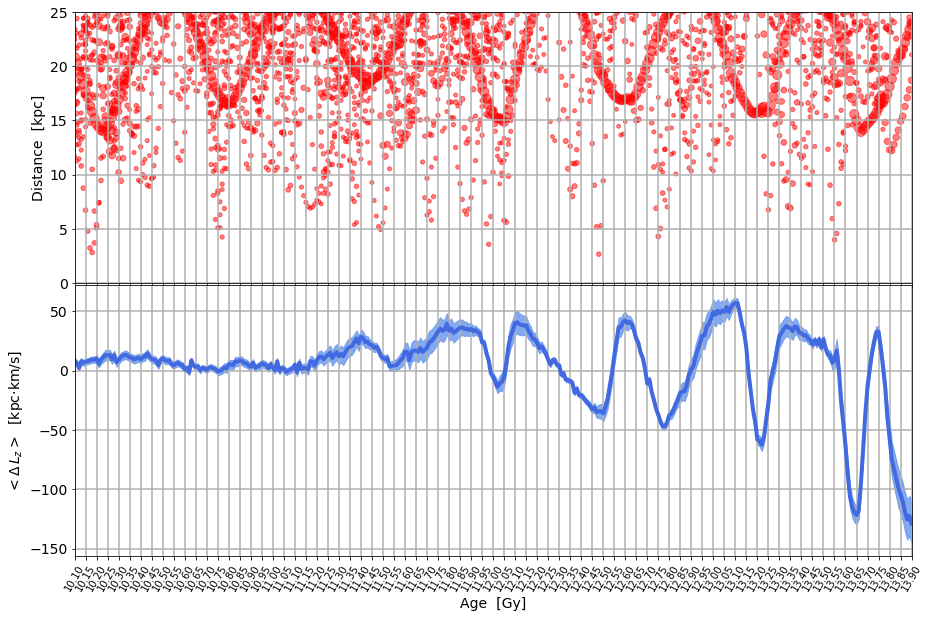

In [23]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=14)


plt.subplot(2,1,1)
for i in range(len(distances_sorted_by_t)):
    sizes = 15 * (np.log10(masses_sorted_by_t[i]) - 6)
#    plt.axvline(x=times_sorted_by_t[i][0], ls='--', color='gray', alpha=0.2)
    plt.scatter(times_sorted_by_t[i], distances_sorted_by_t[i], c='r', alpha=0.5, s=sizes)

    
plt.ylim(0, 25)
plt.xlim(10.1, 13.9)
plt.xticks(np.arange(10.1,13.9,0.05), labels=[])
plt.grid(lw=1.5)
plt.ylabel('Distance  [kpc]')


plt.subplot(2,1,2)


plt.fill_between(x=encounter_time_axis, y1=minus_err, y2=plus_err,
                 color='cornflowerblue', alpha=0.8)
                 #label=r'1 $\sigma$/$\sqrt{N}$')

plt.plot(encounter_time_axis, avg_Lz, lw=4, c='royalblue')


#timestamp = d[t1]['time']
#delta_time = float(d[t2]['time']) - float(d[t1]['time'])

plt.xlim(10.1, 13.9)
plt.xticks(np.arange(10.1,13.9,0.05), rotation=60, size=10)
plt.grid(lw=1.5)
plt.xlabel('Age  [Gy]')
plt.ylabel(r'$ <\Delta \, L_z> $  [kpc$\cdot$km/s]')


plt.subplots_adjust(hspace=0.01)

#plt.savefig('Angmome_and_encounters.pdf', format='pdf', bbox_inches='tight')

plt.show()

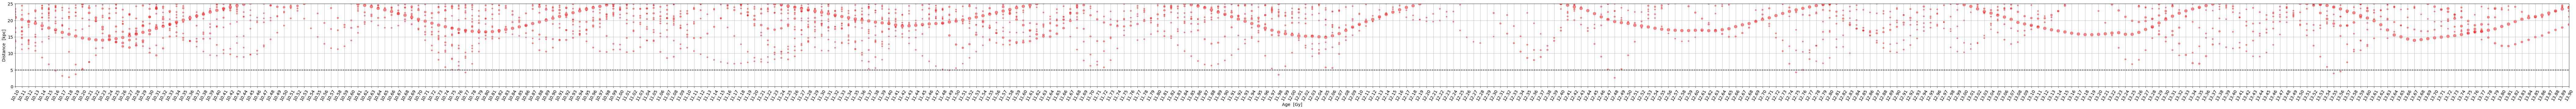

In [24]:
plt.figure(figsize=(150, 5))
plt.rc('font', size=14)

for i in range(len(distances_sorted_by_t)):
    sizes = 15 * (np.log10(masses_sorted_by_t[i]) - 6)
    plt.scatter(times_sorted_by_t[i], distances_sorted_by_t[i], c='r', alpha=0.5, s=sizes)

plt.axhline(y=5, ls='--', color='black')
    
plt.ylim(0, 25)
plt.xlim(10.1, 13.9)
plt.xticks(np.arange(10.1,13.9,0.01), rotation=60)
plt.grid()

plt.xlabel('Age  [Gy]')
plt.ylabel('Distance  [kpc]')

plt.show()

In [25]:
encounter_times = [10.18, 10.77, 11.49, 11.98, 12.48, 12.75, 13.55]

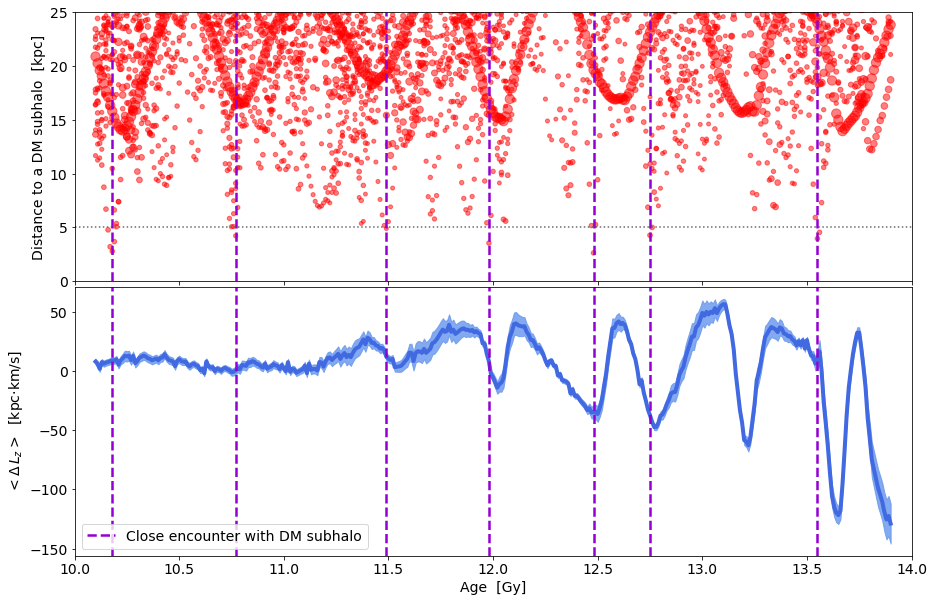

In [27]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=14)


plt.subplot(2,1,1)

plt.axhline(y=5, ls=':', color='dimgrey')

for i in range(len(distances_sorted_by_t)):
    sizes = 15 * (np.log10(masses_sorted_by_t[i]) - 6)
    plt.scatter(times_sorted_by_t[i], distances_sorted_by_t[i], c='r', alpha=0.5, s=sizes)

for encounter_time in encounter_times:
    plt.axvline(x=encounter_time, ls='--', color='darkviolet', lw=2.5)

    
plt.ylim(0, 25)
plt.xlim(10, 14)
plt.xticks(np.arange(10, 14.1, 0.5), labels=[])

plt.ylabel('Distance to a DM subhalo  [kpc]')


plt.subplot(2,1,2)


plt.fill_between(x=encounter_time_axis, y1=minus_err, y2=plus_err,
                 color='cornflowerblue', alpha=0.8)

plt.plot(encounter_time_axis, avg_Lz, lw=4, c='royalblue')

for i, encounter_time in enumerate(encounter_times):
    if i == 0:
        plt.axvline(x=encounter_time, ls='--', color='darkviolet', lw=2.5, 
                    label='Close encounter with DM subhalo')
    else:
        plt.axvline(x=encounter_time, ls='--', color='darkviolet', lw=2.5)


plt.xlim(10, 14)
plt.xticks(np.arange(10, 14.1, 0.5))

##
##plt.yticks(np.arange(-20, 60, 10))
##

plt.xlabel('Age  [Gy]')
plt.ylabel(r'$ <\Delta \, L_z> $  [kpc$\cdot$km/s]')

plt.legend(loc='lower left')


plt.subplots_adjust(hspace=0.02)

plt.savefig('Extra_228_punctuated.png', format='png', bbox_inches='tight')

plt.show()